Zadanie 2

Symulowanie rozkładu normalnego metodą odwrotnej dystrybuanty.

In [2]:
import random
import numpy as np
import math
from scipy.special import erfinv
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [3]:

def norm_inv_cdf(mi, sig, num):
    sample = np.random.rand(num)
    return mi + sig * math.sqrt(2) * erfinv(2 * sample - 1)

In [6]:
mi = 0
sigma = 1
n_norm = 1000
ts = np.linspace(-4,4, 1000)

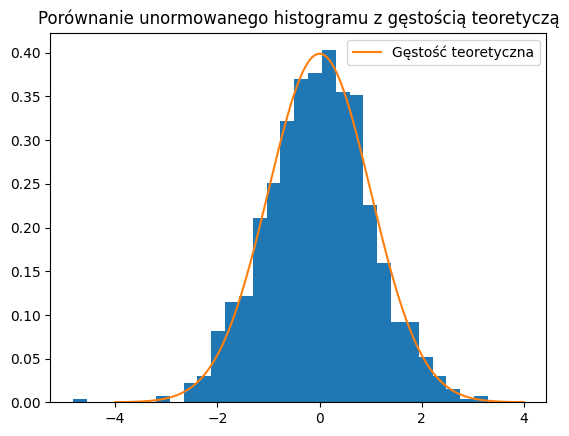

In [35]:
sample_inv_cdf = norm_inv_cdf(mi, sigma, n_norm)
plt.hist(sample_inv_cdf, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

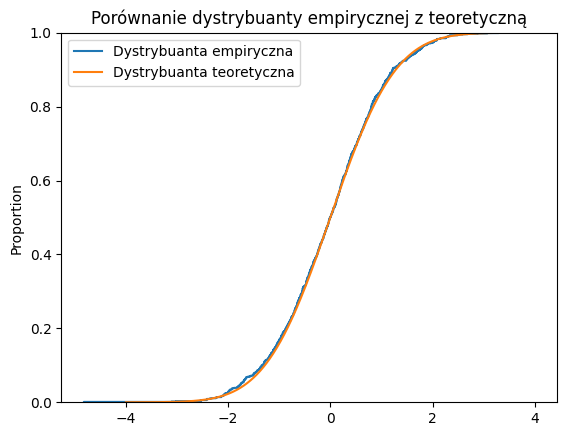

In [37]:
sns.ecdfplot(sample_inv_cdf, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

In [12]:
def exp_simulation(num, lambda_):
    sample = np.random.rand(num)
    return (-1)/lambda_ * np.log(1-sample)

In [25]:
def norm_using_exp(mi, sigma, n):
    samples = []
    iterations = 1
    sigmas = [sigma] * n
    mis = [mi] * n
    while len(samples) < n:
        iterations += 1
        y = exp_simulation(1,1)[0]
        u = np.random.uniform()
        if u <= np.exp(-(y-1)**2/2):
            u2 = np.random.uniform()
            if u2 < 0.5:
                samples.append(y)
            else:
                samples.append(-y)
    return np.add(np.divide(samples,sigmas), mis), n*100/iterations
    

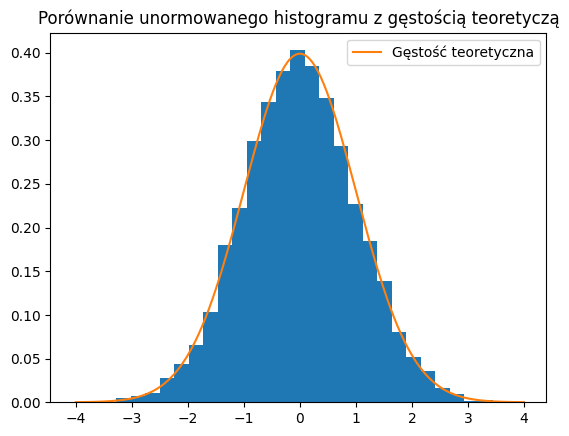

In [26]:
sample_using_exp = norm_using_exp(mi, sigma, n_norm)[0]
plt.hist(sample_using_exp, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

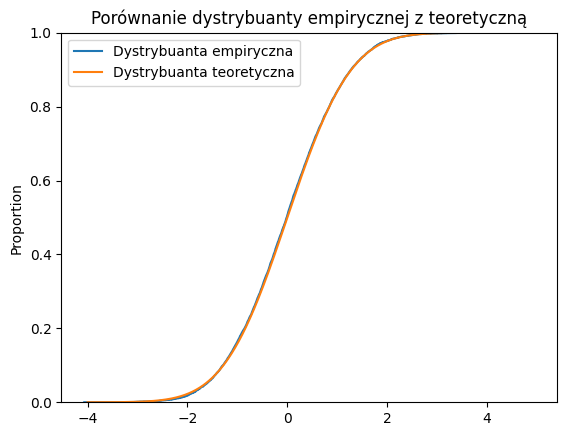

In [17]:
sns.ecdfplot(sample_using_exp, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

In [27]:
def ratio_of_uniforms(mi, sigma, n):
    lista_x = []
    lista_y = []
    sigmas = [sigma] * n
    mis = [mi] * n
    while len(lista_x) < n:
        x_losowy = random.uniform(0,1)
        y_losowy = random.uniform(-1,1)
        if -2*x_losowy*np.sqrt((-1)*np.log(x_losowy))<y_losowy<2*x_losowy*np.sqrt((-1)*np.log(x_losowy)):
            lista_x.append(x_losowy)
            lista_y.append(y_losowy)
    arr1 = np.array(lista_x)
    arr2 = np.array(lista_y)
    odp = arr2/arr1
    return np.add(np.divide(odp,sigmas), mis)


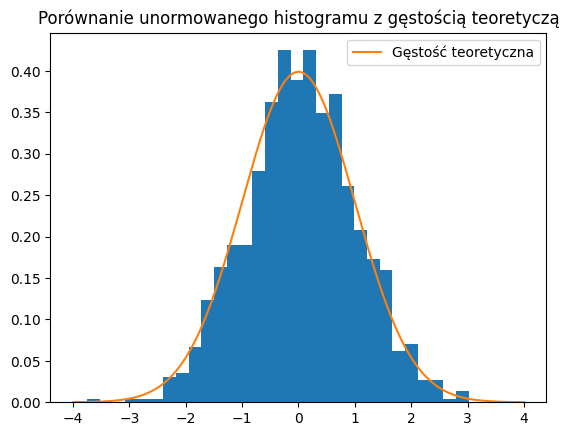

In [38]:
sample_ratio_of_uni = ratio_of_uniforms(mi, sigma, n_norm)
plt.hist(sample_ratio_of_uni, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

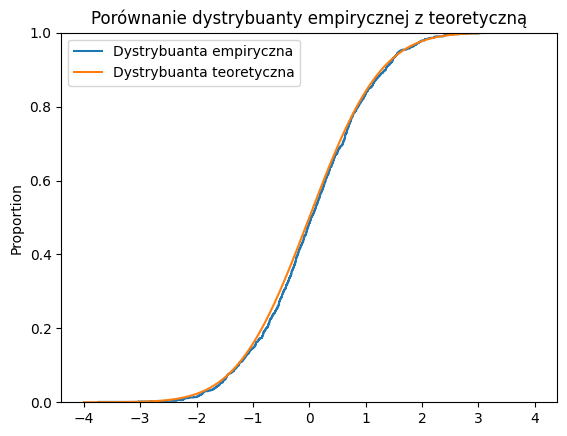

In [39]:
sns.ecdfplot(sample_ratio_of_uni, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

In [40]:
def box_muller(n, mu, sigma):
    m1 = [mu] * n
    s1 = [sigma] * n
    samples = []
    while len(samples) < n:
        u = np.random.random()
        v = np.random.random()
        r = np.sqrt(-2 * np.log(u))
        theta = 2 * np.pi * v
        samples.append(r * np.cos(theta))
        samples.append(r * np.sin(theta))
    return np.add(np.multiply(samples, s1), m1)

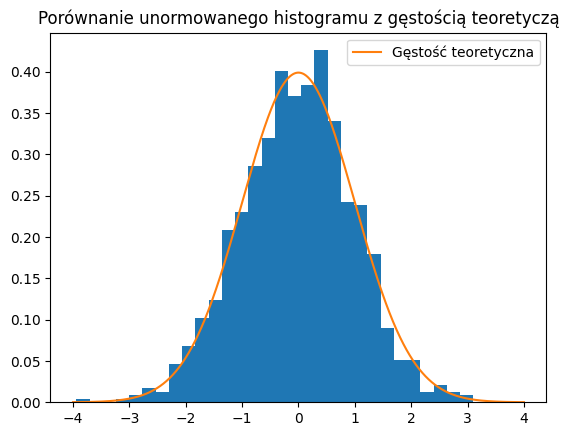

In [41]:
sample_box_muller = box_muller(n_norm, mi, sigma)
plt.hist(sample_box_muller, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

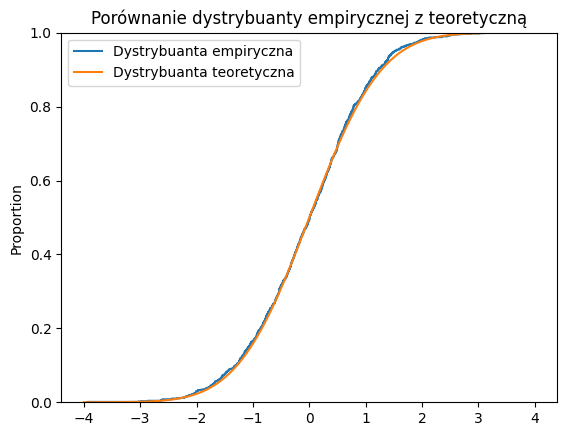

In [42]:
sns.ecdfplot(sample_box_muller, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

In [43]:
def marsaglia(n, mi, sigma):
    sigmas = [sigma] * n
    mis = [mi] * n
    samples = []
    while len(samples) < n:
        y1, y2 = np.random.uniform(-1,1,2)
        r = y1**2 + y2**2
        if r < 1:
            y = np.sqrt(-2*np.log(r)/r)
            x1, x2 = y1 * y, y2 * y
            samples.append(x1)
            samples.append(x2)
    return np.add(np.multiply(samples,sigmas), mis)

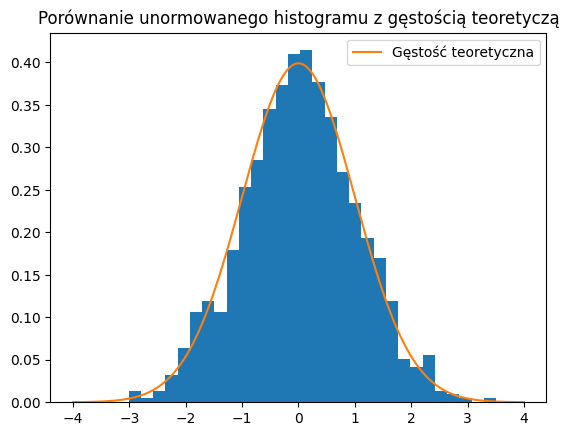

In [62]:
sample_marsaglia = marsaglia(n_norm, mi, sigma)
plt.hist(sample_marsaglia, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

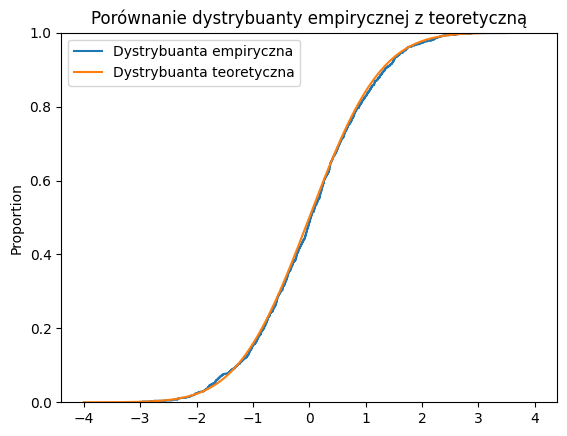

In [63]:
sns.ecdfplot(sample_marsaglia, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Metoda "tuzina"

In [3]:
def dozen(mi, sigma, n):
    s = [np.sum(np.random.rand(12)) for i in range(n)]
    xs = np.subtract(s, 6*np.ones(n))
    ys = np.add(np.multiply(xs, sigma*np.ones(n)), mi*np.ones(n))
    return ys

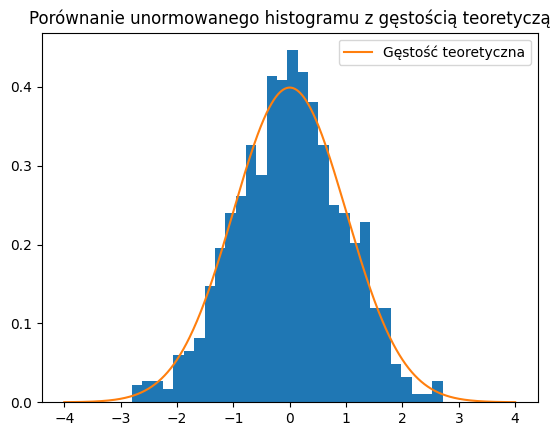

In [7]:
sample_dozen = dozen(mi, sigma, 1000)
plt.hist(sample_dozen, density=True, bins=30)
plt.plot(ts, norm.pdf(ts, mi, 1/sigma), label = "Gęstość teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie unormowanego histogramu z gęstością teoretyczą")
plt.show()

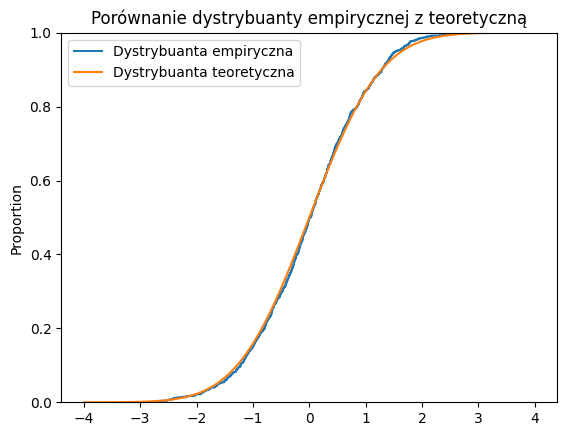

In [9]:
sns.ecdfplot(sample_dozen, label = "Dystrybuanta empiryczna")
plt.plot(ts, norm.cdf(ts, mi, 1/sigma), label="Dystrybuanta teoretyczna")
plt.legend(loc="best")
plt.title("Porównanie dystrybuanty empirycznej z teoretyczną")
plt.show()

Ziggurat

In [10]:
def przedzialy(f, k, x_0, x_k):
    xs = np.linspace(x_0, x_k, k)
    f_min = []
    f_max = []
    for i in range(k-1):
        f_min.append(min([f(j) for j in np.linspace(xs[i], xs[i+1], 10**3)]))
        f_max.append(max([f(j) for j in np.linspace(xs[i], xs[i+1], 10**3)]))
    return f_min, f_max

In [11]:
def ziggurat(f, g, f_min, f_max, k, x_0, x_k, n, c):
    xs = np.linspace(x_0, x_k, k)
    samples = []
    while len(samples) < n:
        u = np.random.uniform()
        u2 = np.random.uniform(-1,1)
        x = exp_simulation(1,1)[0]
        ind = 0
        for i in range(k-1):
            if xs[i] <= x <= xs[i+1]:
                ind = i
        if u*c*g(x) < f_min[ind]:
            if u2 > 0:
                samples.append(x)
            else:
                samples.append(-x)
        elif u*c*g(x) > f_max[ind]:
            continue
        else:
            if u*c*g(x) < f(x):
                if u2 > 0:
                    samples.append(x)
                else:
                    samples.append(-x)
    return samples

In [16]:
def exp_simulation(num, lambda_):
    sample = np.random.rand(num)
    return (-1)/lambda_ * np.log(1-sample)

In [12]:
def exp_cdf(x):
    return np.exp(-x)

In [13]:
def normal_cdf(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [14]:
k = 100
x_0 = -10
x_k = 10
n = 10000
c = 1/np.sqrt(np.exp(1))
f_min, f_max = przedzialy(normal_cdf, k, x_0, x_k)


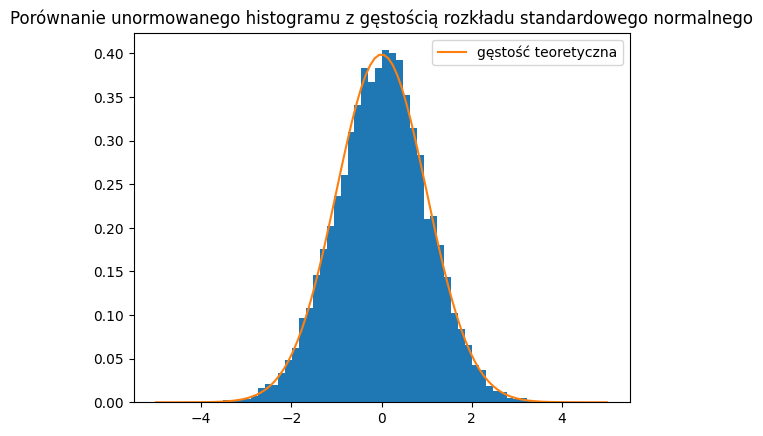

In [18]:
samples = ziggurat(normal_cdf, exp_cdf, f_min, f_max, k, x_0, x_k, n, c)
xs = np.linspace(-5,5, 100)
plt.hist(samples, density=True, bins=50)
plt.plot(xs, norm.pdf(xs, 0, 1), label="gęstość teoretyczna")
plt.title("Porównanie unormowanego histogramu z gęstością rozkładu standardowego normalnego")
plt.legend(loc='best')
plt.show()

In [120]:
n = 255
v = 0.00492867323399
r = 3.6541528853610088 
def ziggurat2(n, r, v, mi, sigma):
    xs = np.zeros(n+1)
    xs[n] = r
    for i in range(n-1,0,-1):
        xs[i] = np.sqrt(-np.log((v/xs[i+1]+norm.pdf(xs[i+1], 0, 1))**2))
    run=True
    while run:
        u = np.random.rand(5)
        i = 1 + math.floor(n * u[0])
        x = xs[i] * u[1]
        if np.absolute(x) < xs[i-1]:
            X = x
            run = False
        if i != n:
            y = (norm.pdf(xs[i-1]) - norm.pdf(xs[i])) * u[2]
            if y < norm.pdf(x) - norm.pdf(xs[i]):
                X = x
                run = False
        if np.absolute(x) >= xs[i-1]:
            run2 = True
            while run2:
                d, f = -1 + 2*u[3], u[4]
                x, y = -np.log(np.absolute(d))/3, -np.log(f)
                if 2*y > x**2:
                    if d > 0:
                        X = x + 3
                    else:
                        X = -x - 3
                    run = False
    Y = sigma * X + mi
    return Y
            

In [131]:
print(ziggurat2(n, r, v, 0, 1))

0.2836158368822477


In [ ]:
def time_check(func, )